In [7]:
from __future__ import print_function 
%cd /Users/sophiatonelli/library_script/script
from scipy.ndimage import gaussian_filter1d
import tools21cm as t2c
import os, sys 
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import math
from scipy.stats import gaussian_kde
os.chdir('/Users/sophiatonelli/library_script/script/work')
sys.path.append(os.getcwd())
import script
sys.path.append(os.getcwd())
import numpy as np 
import matplotlib.pyplot as plt 
import script 
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 11})

/Users/sophiatonelli/library_script/script


In [8]:
"""
I aim to compare the resolution of the PC and ES methods for the ionization field.
I am using the same box size and ngrid for both methods.
I am using the same matter fields/snapshot for both methods.

To do so, here is the plan:
I am generating the ionization maps for both methods and plotting them.

Here 9 scenarios (with zeta efficiency halo mass independent) are plotted using,
ES method with ngrid 128 to display the diffeerent reionization fields at maximum resolution

ZETA VALS ARE SAVED IN NUMPY ARRAY
"""

'\nI aim to compare the resolution of the PC and ES methods for the ionization field.\nI am using the same box size and ngrid for both methods.\nI am using the same matter fields/snapshot for both methods.\n\nTo do so, here is the plan:\nI am generating the ionization maps for both methods and plotting them.\n\nHere 9 scenarios (with zeta efficiency halo mass independent) are plotted using,\nES method with ngrid 128 to display the diffeerent reionization fields at maximum resolution\n\nZETA VALS ARE SAVED IN NUMPY ARRAY\n'

In [9]:
gadget_snap = '/Users/sophiatonelli/Downloads/snap_120' 
outpath = '/Users/sophiatonelli/library_script/script/work/script_files' 
scaledist = 1e-3 
default_simulation_data = script.default_simulation_data(gadget_snap, outpath, sigma_8=0.829, ns=0.961, omega_b=0.0482, scaledist=scaledist) 

print("Simulation box size:", default_simulation_data.box, "cMpc/h") 
print("Simulation redshift:", default_simulation_data.z)

Simulation box size: 256.0 cMpc/h
Simulation redshift: 8.0


In [10]:
#(i.e. resolution 256/128 cMpc/h)
ngrid = 42 #64 #128, 64, 42, 32
matter_fields = script.matter_fields(default_simulation_data, ngrid, outpath, overwrite_files=False) 
list_xhi_vals = [0.2, 0.5, 0.7]      #target mean neutral fractions
list_log10Mmin_vals = [8.0, 9.0, 10.0]  #log10(Mmin)


In [13]:
#ES METHOD
def compute_xhi_tuning_zeta(target_xhi, zeta, fcoll_arr, matter_fields):
    """
    1 - Q = xHI

    ionization_map using ES method
    define Q from map
    compute xHI = 1 - Q * (1 + delta) #weighted by density contrast
    target_xhi is the mean neutral fraction we want to achieve
    zeta is the ionization efficiency parameter we want to tune
    xHI - xHI_target = 0
    I find the zeta that makes this equation true
    """
    ionization_map = script.ionization_map(matter_fields, method='ES') #filter 
    qi_arr = ionization_map.get_qi(zeta * fcoll_arr)
    delta = matter_fields.densitycontr_arr
    xHI_mean = np.mean(1 - qi_arr * (1 + delta))
    return xHI_mean - target_xhi

def tune_zeta_ES(fcoll_arr, matter_fields, target_xhi, zeta_guess=30):
    """
    root finding to tune zeta for the ES method
    to achieve a target mean neutral fraction xHI
    """

    def func(zeta):
        
        return compute_xhi_tuning_zeta(target_xhi, zeta, fcoll_arr, matter_fields)
    
    result = root_scalar(func, bracket=[1, 200], method='bisect') #[1,200]
    return result.root if result.converged else None

In [14]:
import pickle

zeta_es_vals=[]
#loop over the different Mmin values
#and tune zeta for each Mmin to achieve the target xHI values
#and save the tuned zeta values in a list
for log10Mmin in list_log10Mmin_vals:
    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    fcoll_mean = fcoll_arr.mean()
    print(f"\nlog10(Mmin): {log10Mmin:.1f}  fcoll mean: {fcoll_mean:.4f}")

    for target_xhi in list_xhi_vals:
        tuned_zeta = tune_zeta_ES(fcoll_arr, matter_fields, target_xhi)
        print(f" Target xHI: {target_xhi:.2f}  Tuned zeta: {tuned_zeta}")
        zeta_es_vals.append(tuned_zeta) #res 128: logM9, xhi05, zeta=27.710480690001297, res64: zeta=26.94838047027531



log10(Mmin): 8.0  fcoll mean: 0.0464
 Target xHI: 0.20  Tuned zeta: 16.895085334778948
 Target xHI: 0.50  Tuned zeta: 10.227811556309462
 Target xHI: 0.70  Tuned zeta: 6.085415124893153

log10(Mmin): 9.0  fcoll mean: 0.0183
 Target xHI: 0.20  Tuned zeta: 42.224824905394335
 Target xHI: 0.50  Tuned zeta: 26.046615570783615
 Target xHI: 0.70  Tuned zeta: 15.096125125886253

log10(Mmin): 10.0  fcoll mean: 0.0038
 Target xHI: 0.20  Tuned zeta: 197.96088409423942
 Target xHI: 0.50  Tuned zeta: 129.5881068110466
 Target xHI: 0.70  Tuned zeta: 73.97571182250948


In [15]:
print("\nAll zeta values (should be 9):", zeta_es_vals)


All zeta values (should be 9): [16.895085334778948, 10.227811556309462, 6.085415124893153, 42.224824905394335, 26.046615570783615, 15.096125125886253, 197.96088409423942, 129.5881068110466, 73.97571182250948]


In [16]:
zeta_es_vals = np.array(zeta_es_vals)

#np.save('zeta_es_array_redsh8.npy', zeta_es_vals) #save zeta_es_array to a numpy to export it CHECK NGRID

Zeta array shape: (3, 3)
Zeta array:
 [[ 16.89508533  10.22781156   6.08541512]
 [ 42.22482491  26.04661557  15.09612513]
 [197.96088409 129.58810681  73.97571182]]


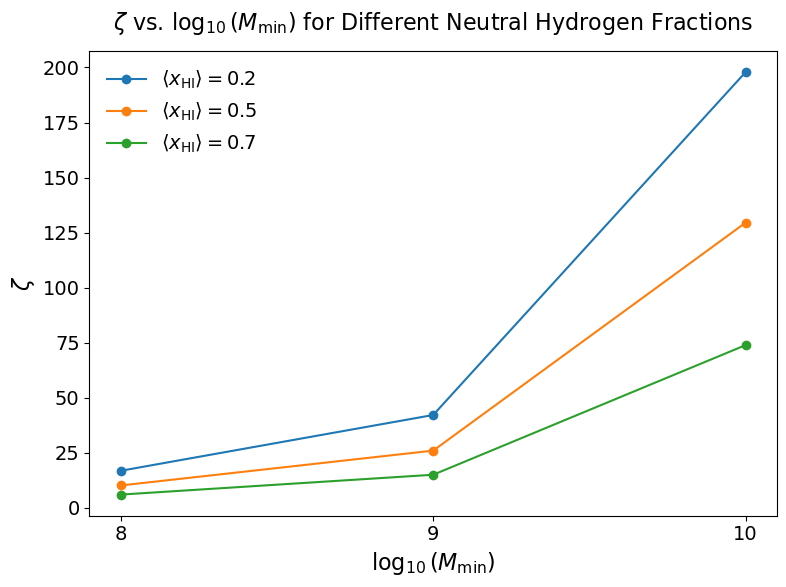

In [17]:
#2:
import math
zeta_es_array = np.array(zeta_es_vals).reshape(len(list_log10Mmin_vals), len(list_xhi_vals)) #do 3 rows and 3 columns reshape
print("Zeta array shape:", zeta_es_array.shape)
print("Zeta array:\n", zeta_es_array)

#plot: for each xhi, plot zeta vs log10Mmin
plt.figure(figsize=(8, 6))

for j, target_xhi in enumerate(list_xhi_vals):
    plt.plot(list_log10Mmin_vals, zeta_es_array[:, j], marker='o', label=rf"$\langle x_{{\mathrm{{HI}}}} \rangle = {target_xhi}$")

plt.xlabel(r'$\log_{10}(M_{\mathrm{min}})$', fontsize=16)
plt.ylabel(r'$\zeta$',fontsize=16)
plt.xticks(list_log10Mmin_vals)  #set x-ticks to match Mmin values
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title(r'$\zeta$ vs. $\log_{10}(M_{\mathrm{min}})$ for Different Neutral Hydrogen Fractions', fontsize=16, pad=15)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()
plt.show()


log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 16.895085334778948
qi_arr mean: 0.80793566
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 10.227811556309462
qi_arr mean: 0.47551882
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 6.085415124893153
qi_arr mean: 0.2823917
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 42.224824905394335
qi_arr mean: 0.8176716
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 26.046615570783615
qi_arr mean: 0.4832067
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 15.096125125886253
qi_arr mean: 0.27714247
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 197.96088409423942
qi_arr mean: 0.8208198
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 129.5881068110466
qi_arr mean: 0.51147175
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 73.97571182250948
qi_arr mean: 0.28221685


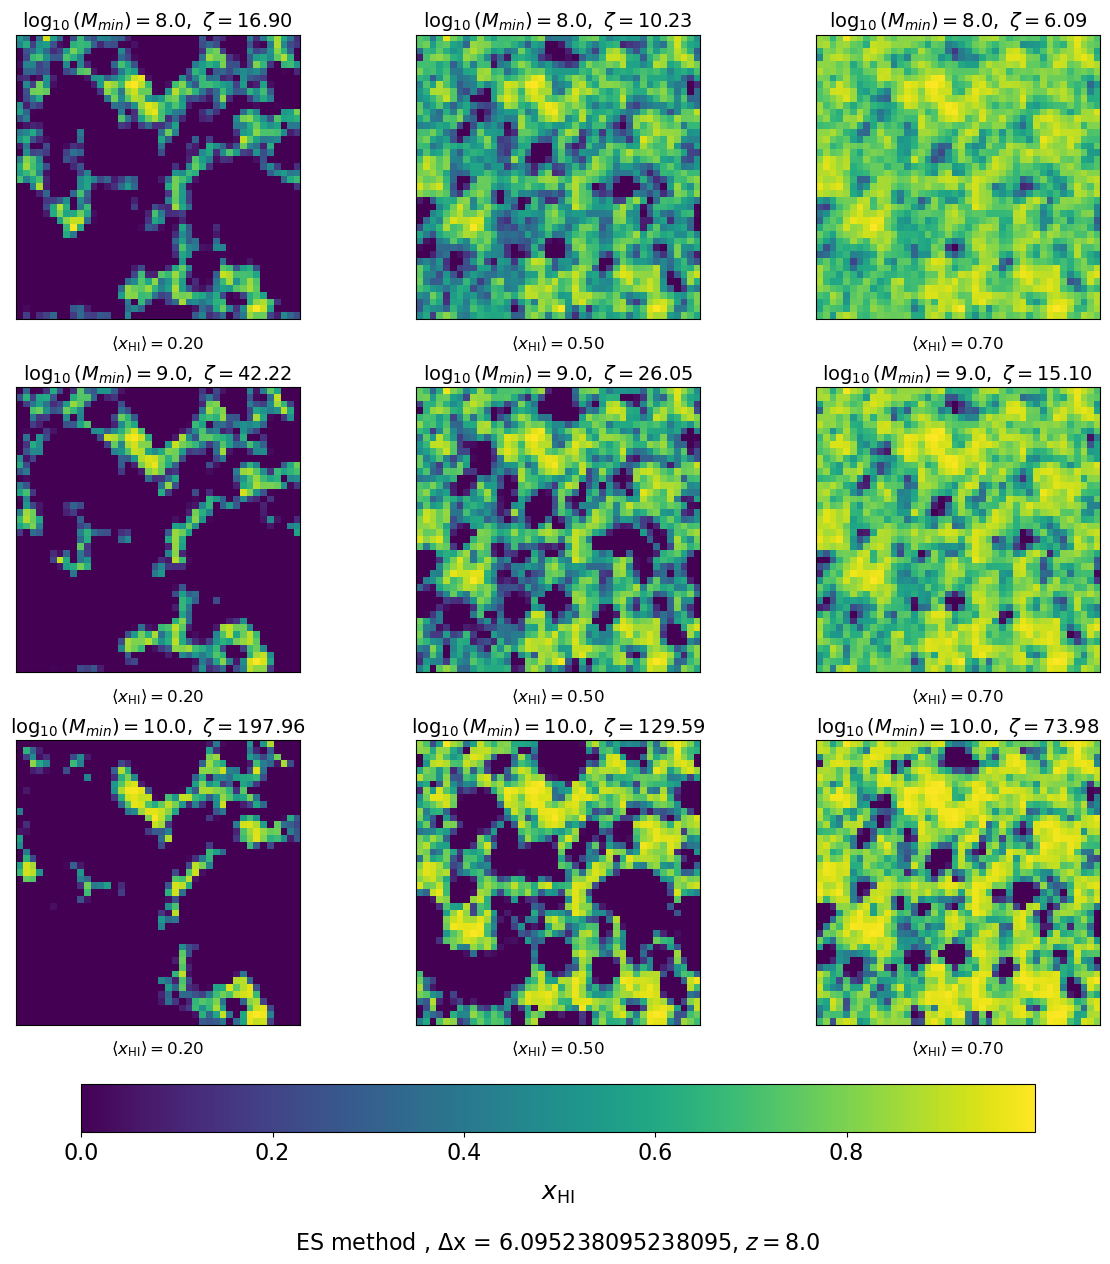

In [18]:
cell_size = default_simulation_data.box / ngrid  #128 cMpc/h
#3:
nrows, ncols = 3, 3  #3 log10Mmin, 3 zeta per log10Mmin
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

for j in range(9):
    i = j // 3         #which log10Mmin (row)
    k = j % 3          #which zeta within that Mmin group (column)
    
    log10Mmin = list_log10Mmin_vals[i]
    zeta = zeta_es_vals[j]
    xhi=list_xhi_vals[k]

    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    print("log10(Mmin):", log10Mmin, "fcoll:", fcoll_arr.mean())
    print("zeta:", zeta)

    ionization_map = script.ionization_map(matter_fields)
    qi_arr = ionization_map.get_qi(zeta * fcoll_arr)
    print("qi_arr mean:", qi_arr.mean())

    ax = axes[i, k]  

    im = ax.imshow(
        1 - qi_arr[:, :, int(0.5*ngrid)],
        extent=[0, default_simulation_data.box, 0, default_simulation_data.box],
        cmap='viridis'
    )
    ax.set_title(rf"$\log_{{10}}(M_{{min}})={log10Mmin},\ \zeta={zeta:.2f}$",
                 fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.text(
        0.5, -0.05,
        f"$\\langle x_{{\\mathrm{{HI}}}} \\rangle = {xhi:.2f}$", #1 - qi_arr.mean():.2f
        fontsize=12,
        ha='center',
        va='top',
        transform=ax.transAxes
    )
fig.text(
    0.5, -0.02, rf'ES method , Δx = {cell_size}, $z={default_simulation_data.z:.1f}$',
    fontsize=16,
    ha='center',
    va='top'
)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, pad=0.02,
                    label=r'$x_{\mathrm{HI}}$', orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$x_{\mathrm{HI}}$', fontsize=18, labelpad=12)
plt.show()

log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 16.895085334778948
qi_arr mean: 0.80793566
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 10.227811556309462
qi_arr mean: 0.47551882
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 6.085415124893153
qi_arr mean: 0.2823917
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 42.224824905394335
qi_arr mean: 0.8176716
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 26.046615570783615
qi_arr mean: 0.4832067
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 15.096125125886253
qi_arr mean: 0.27714247
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 197.96088409423942
qi_arr mean: 0.8208198
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 129.5881068110466
qi_arr mean: 0.51147175
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 73.97571182250948
qi_arr mean: 0.28221685


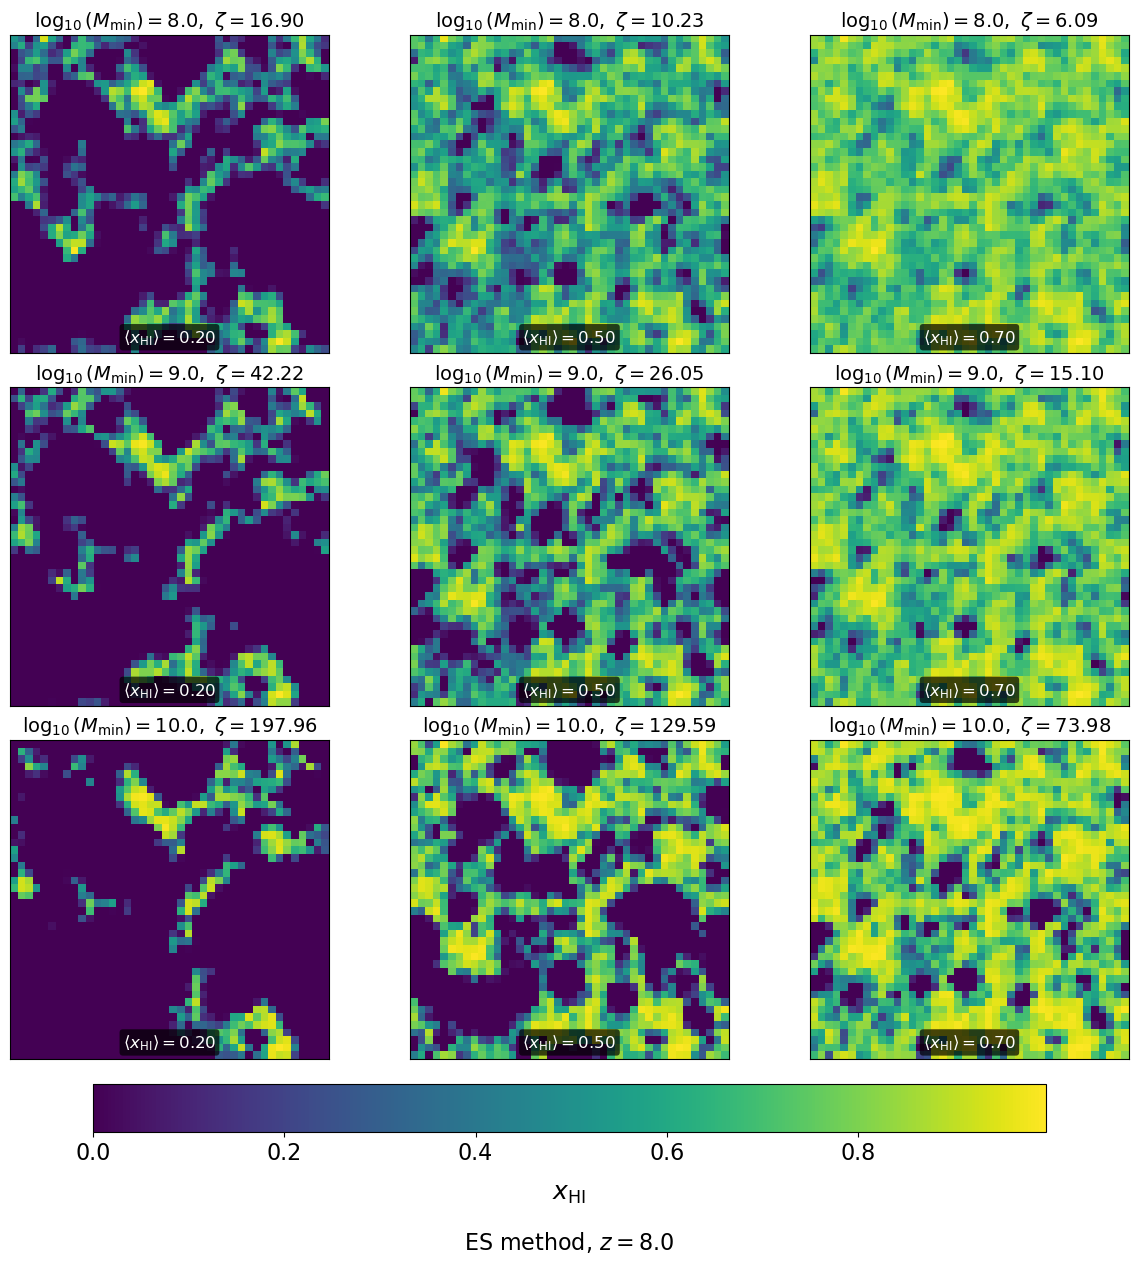

In [19]:
nrows, ncols = 3, 3  # 3 log10Mmin, 3 zeta per log10Mmin
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

for j in range(9):
    i = j // 3         # which log10Mmin (row)
    k = j % 3          # which zeta within that Mmin group (column)

    log10Mmin = list_log10Mmin_vals[i]
    zeta = zeta_es_vals[j]
    xhi=list_xhi_vals[k]  # Assuming this corresponds to zeta_es_vals[j]

    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    print("log10(Mmin):", log10Mmin, "fcoll:", fcoll_arr.mean())
    print("zeta:", zeta)

    ionization_map = script.ionization_map(matter_fields)
    qi_arr = ionization_map.get_qi(zeta * fcoll_arr)
    print("qi_arr mean:", qi_arr.mean())

    ax = axes[i, k]

    im = ax.imshow(
        1 - qi_arr[:, :, int(0.5*ngrid)],
        extent=[0, default_simulation_data.box, 0, default_simulation_data.box],
        cmap='viridis'
    )

    # Title only with Mmin and zeta
    ax.set_title(
        rf"$\log_{{10}}(M_{{\min}})={log10Mmin},\ \zeta={zeta:.2f}$",
        fontsize=14
    )
    ax.set_xticks([])
    ax.set_yticks([])

    #white label ⟨x_HI⟩ inside each panel
    ax.text(
        0.5, 0.02,  # small margin from bottom
        rf"$\langle x_{{\mathrm{{HI}}}} \rangle = {xhi:.2f}$",
        fontsize=12,
        ha='center',
        va='bottom',
        color='white',
        transform=ax.transAxes,
        bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
    )


fig.text(
    0.5, -0.02, rf'ES method, $z={default_simulation_data.z:.1f}$',
    fontsize=16,
    ha='center',
    va='top'
)


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, pad=0.02,
                    label=r'$x_{\mathrm{HI}}$', orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$x_{\mathrm{HI}}$', fontsize=18, labelpad=12)

plt.show()


log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 16.895085334778948
qi_arr mean: 0.80793566
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 10.227811556309462
qi_arr mean: 0.47551882
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 6.085415124893153
qi_arr mean: 0.2823917
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 42.224824905394335
qi_arr mean: 0.8176716
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 26.046615570783615
qi_arr mean: 0.4832067
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 15.096125125886253
qi_arr mean: 0.27714247
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 197.96088409423942
qi_arr mean: 0.8208198
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 129.5881068110466
qi_arr mean: 0.51147175
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 73.97571182250948
qi_arr mean: 0.28221685


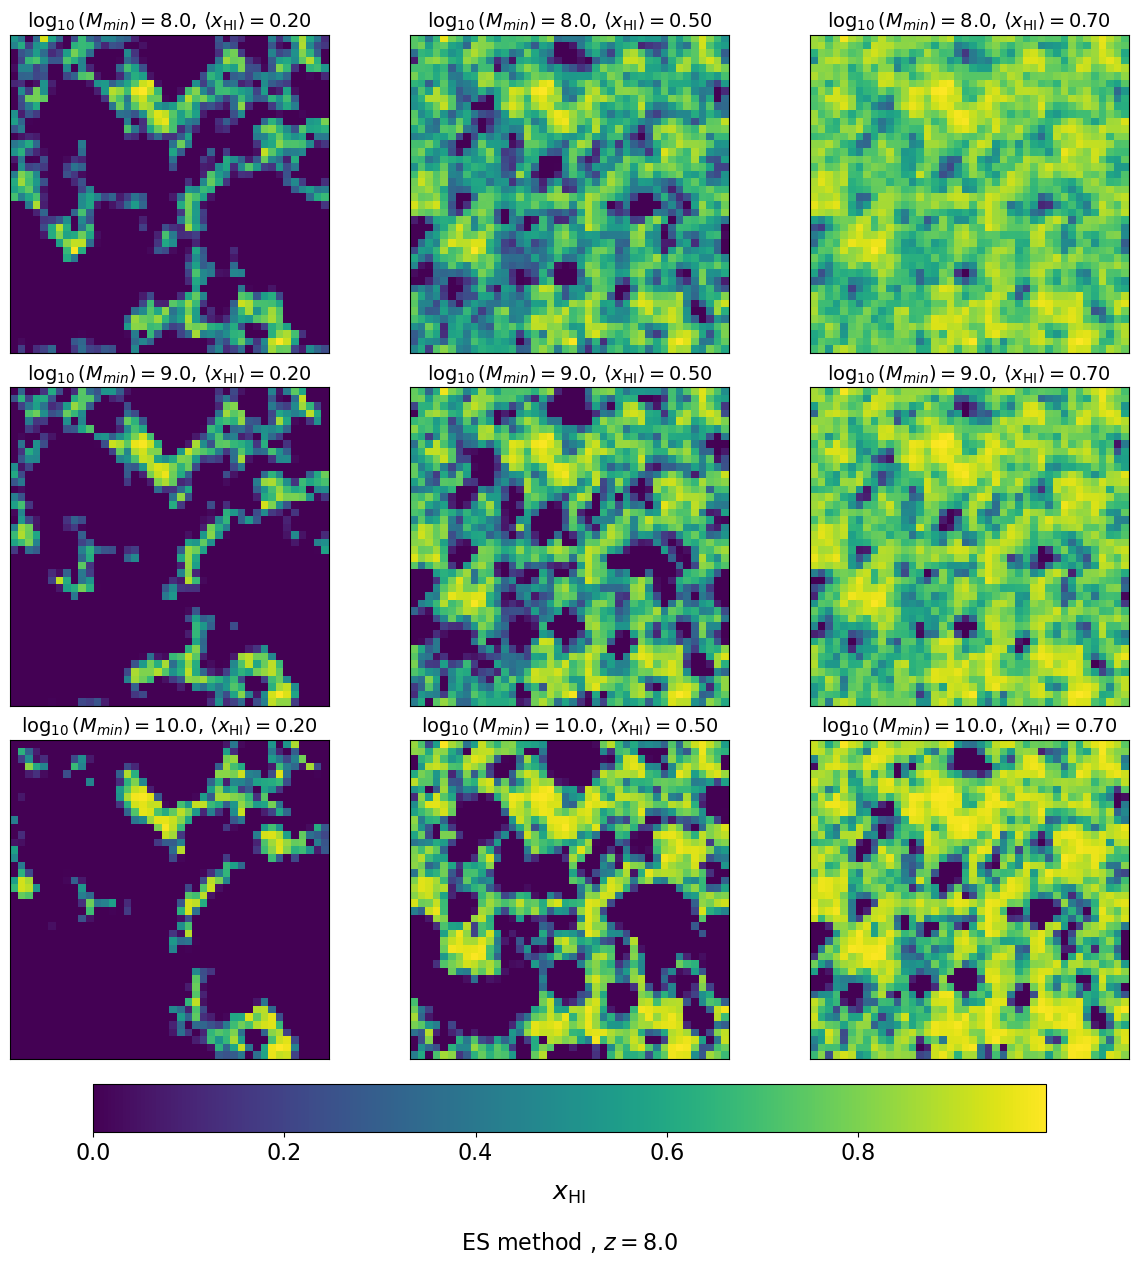

In [20]:
#extra version of the panel plot with ES method
#less text, for neat visualization



nrows, ncols = 3, 3  #3 log10Mmin, 3 zeta per log10Mmin
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

for j in range(9):
    i = j // 3         #which log10Mmin (row)
    k = j % 3          #which zeta within that Mmin group (column)
    
    log10Mmin = list_log10Mmin_vals[i]
    zeta = zeta_es_vals[j]
    xhi=list_xhi_vals[k]

    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    print("log10(Mmin):", log10Mmin, "fcoll:", fcoll_arr.mean())
    print("zeta:", zeta)

    ionization_map = script.ionization_map(matter_fields)
    qi_arr = ionization_map.get_qi(zeta * fcoll_arr)
    print("qi_arr mean:", qi_arr.mean())

    ax = axes[i, k]  

    im = ax.imshow(
        1 - qi_arr[:, :, int(0.5*ngrid)],
        extent=[0, default_simulation_data.box, 0, default_simulation_data.box],
        cmap='viridis'
    )
    ax.set_title(rf"$\log_{{10}}(M_{{min}})={log10Mmin}$, " + rf"$\langle x_{{\mathrm{{HI}}}} \rangle = {xhi:.2f}$",
                 fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])


fig.text(
    0.5, -0.02, rf'ES method , $z={default_simulation_data.z:.1f}$',
    fontsize=16,
    ha='center',
    va='top'
)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, pad=0.02,
                    label=r'$x_{\mathrm{HI}}$', orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$x_{\mathrm{HI}}$', fontsize=18, labelpad=12)
plt.show()